In [181]:
%pylab inline

import pandas as pd
import scipy.stats as stats
import polygon
import tqdm
import seaborn as sns

plt.style.use('seaborn')
rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [50]:
from importlib import reload
reload(polygon)
api = polygon.REST()

In [10]:
# Get SPX top50 components.
spx = pd.read_csv('data/spx.csv')[:50]
spx.index = spx.Ticker
spx = spx.Weight / spx.Weight.sum()

In [212]:
def download(symbol: str):
    aggs = api.aggs(symbol, 1, 'minute', '2017-03-28', '2022-03-28', limit=50000)
    while aggs.index[-1] <= pd.to_datetime('2022-03-25'):
        s_date = aggs.index[-1] + datetime.timedelta(days=1)
        aggs = aggs.append(api.aggs(symbol, 1, 'minute', s_date.strftime('%Y-%m-%d'), '2022-03-28', limit=50000))
    aggs.index = aggs.index.tz_localize('UTC').tz_convert('US/Eastern')
    aggs = aggs.loc[(aggs.index.time >= datetime.time(9,30)) & (aggs.index.time < datetime.time(16,0))]
    aggs.to_csv(f'data/{symbol}.csv')
    
def download_all():
    for symbol in tqdm.tqdm(spx.index):
        download(symbol)
        
def load_df() -> pd.DataFrame:
    df = pd.read_csv('data/top50.csv', index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    return df
        
def load_data(symbol: str) -> pd.DataFrame:
    aggs = pd.read_csv(f'data/{symbol}.csv', index_col=0)
    aggs.index = pd.to_datetime(aggs.index, utc=True).tz_convert('US/Eastern')
    return aggs
        
def load_all() -> pd.DataFrame:
    df = pd.DataFrame()
    for symbol in tqdm.tqdm(spx.index):
        aggs = load_data(symbol)
        df[symbol] = aggs.c
    return df

def slice_day(df: pd.DataFrame, date) -> pd.DataFrame:
    date = pd.to_datetime(date, utc=True).tz_convert('US/Eastern')
    prior_close = df.loc[:date - datetime.timedelta(days=1)].dropna().iloc[-1]
    e_date = date + datetime.timedelta(days=1)
    return df.loc[date:e_date] / prior_close

def fit_dispersion(day: pd.DataFrame):
    disp = (np.log(day).pow(2) * spx).sum(axis=1) - np.log(day.SPY).pow(2)
    t = (day.index - day.index[0]).total_seconds() / (day.index[-1] - day.index[0]).total_seconds()
    pred = pd.Series([0.0]*len(disp), index=disp.index)
    slopes = pd.Series([0.0]*len(disp), index=disp.index)
    for idx in range(30, len(disp)):
        slope, intercept = np.polyfit(np.log(t[1:idx]), np.log(np.sqrt(252*disp.iloc[1:idx])), 1)
        slopes[idx] = slope
        pred[idx] = np.exp(intercept)
    return disp, pred, slopes

In [162]:
df = load_df()

In [223]:
day = slice_day(df, '2021-03-23')

In [224]:
disp, pred, slopes = fit_dispersion(day)

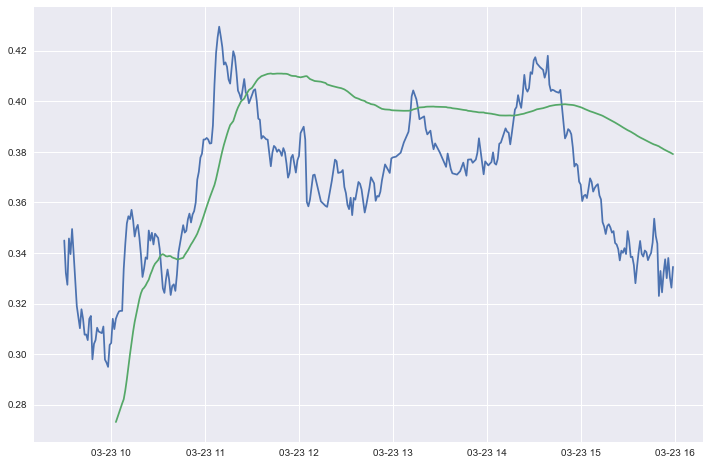

In [225]:
plot(disp.index, np.sqrt(252*disp))
plot(pred[30:])